In [1]:
# to connect to sql
import os
import pymysql

# for ML 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import BaggingClassifier


In [2]:
# Connect to mySQL
host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd='password',
    db="bank",
    charset='utf8mb4')

In [3]:
## GET ALL ACCOUNTS
accounts = pd.read_sql_query('select * from bank.allbeforeML', conn)\
    .set_index('account_id')
print('Shape of ML Data:', accounts.shape)
accounts.head()

Shape of ML Data: (4500, 77)


,loan_id,client_id,district_id,date_loan,amount_loan,duration_loan,payments_loan,status_loan,current_loan,good_status_loan,...,n_munic_10000,n_munic_over,n_cities,urban_ratio,salary,unemploy_95,unemploy_96,n_entre_p1000,n_crimes_95,n_crimes_96
account_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,1,18,None,NaN,NaN,NaN,None,None,None,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
2,4959.0,2,1,1994-01-05,80952.0,24.0,3373.0,A,0,1,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
3,NaN,4,5,None,NaN,NaN,NaN,None,None,None,...,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
4,NaN,6,12,None,NaN,NaN,NaN,None,None,None,...,6,1,6,58.0,8754,3.83,4.31,137,3804,3868
5,NaN,7,15,None,NaN,NaN,NaN,None,None,None,...,7,1,5,51.9,9045,3.13,3.60,124,1845,1879


In [4]:
accounts = pd.get_dummies(accounts,
	columns=['freq_dep_acc','sex_client','user_sex'], drop_first=True)
print('Shape with dummies', accounts.shape)
accounts.head()

Shape with dummies (4500, 78)


,loan_id,client_id,district_id,date_loan,amount_loan,duration_loan,payments_loan,status_loan,current_loan,good_status_loan,...,salary,unemploy_95,unemploy_96,n_entre_p1000,n_crimes_95,n_crimes_96,freq_dep_acc_monthly,freq_dep_acc_weekly,sex_client_M,user_sex_M
account_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,1,18,None,NaN,NaN,NaN,None,None,None,...,8968,2.83,3.35,131,1740,1910,1,0,0,0
2,4959.0,2,1,1994-01-05,80952.0,24.0,3373.0,A,0,1,...,12541,0.29,0.43,167,85677,99107,1,0,1,0
3,NaN,4,5,None,NaN,NaN,NaN,None,None,None,...,9307,3.85,4.43,118,2616,3040,1,0,1,0
4,NaN,6,12,None,NaN,NaN,NaN,None,None,None,...,8754,3.83,4.31,137,3804,3868,1,0,1,0
5,NaN,7,15,None,NaN,NaN,NaN,None,None,None,...,9045,3.13,3.60,124,1845,1879,1,0,1,0


In [5]:
str_to_int_col = ['n_orders_housing','n_orders_loan', 'n_orders_insur', 'n_orders_leas',
              'n_credit_trans','n_withdrawl_trans', 'n_cash_deposit', 'n_bank_collection',
              'n_cash_withdrawl', 'n_bank_remit', 'n_card_withdrawl', 'n_neg_balance',
              'current_loan', 'good_status_loan']

str_to_num_col = ['avg_orders_leas', 'std_orders_leas', 'sum_credit_trans',
                  'avg_credit_trans', 'sum_withdrawl_trans', 'avg_withdrawl_trans',
                  'total_credits_amount', 'total_withdrawls_amount', 'min_balance', 
                  'max_balance', 'n_cards_gold', 'n_cards_classic','n_cards_junior']

accounts[str_to_num_col] = accounts[str_to_num_col].fillna(value=np.nan).astype(float)
accounts[str_to_int_col] = accounts[str_to_int_col].fillna(value=0).astype(int)


In [6]:
# SELECT ONLY ACCOUNTS WITH LOANS TO TRAIN & TEST MODEL
loans = accounts[~accounts['loan_id'].isnull()]
print('Shape of Loans ML Table:', loans.shape)
loans.head()

Shape of Loans ML Table: (682, 78)


,loan_id,client_id,district_id,date_loan,amount_loan,duration_loan,payments_loan,status_loan,current_loan,good_status_loan,...,salary,unemploy_95,unemploy_96,n_entre_p1000,n_crimes_95,n_crimes_96,freq_dep_acc_monthly,freq_dep_acc_weekly,sex_client_M,user_sex_M
account_id,,,,,,,,,,,,,,,,,,,,,
2,4959.0,2,1,1994-01-05,80952.0,24.0,3373.0,A,0,1,...,12541,0.29,0.43,167,85677,99107,1,0,1,0
19,4961.0,25,21,1996-04-29,30276.0,12.0,2523.0,B,0,0,...,9104,1.51,2.07,123,2299,2354,1,0,0,0
25,4962.0,31,68,1997-12-08,30276.0,12.0,2523.0,A,0,1,...,9893,4.09,4.72,96,5623,5887,1,0,1,0
37,4967.0,45,20,1998-10-14,318480.0,60.0,5308.0,D,1,0,...,8547,2.65,3.64,120,1563,1542,1,0,1,0
38,4968.0,46,19,1998-04-19,110736.0,48.0,2307.0,C,1,1,...,8402,3.13,3.98,120,999,1099,0,1,0,0


In [7]:
# CHOOSE FEATURES
cols_X = [ 'n_orders', 'avg_orders_amount',
           'std_orders_amount', 'n_orders_housing', 'avg_orders_housing',
           'std_orders_housing', 'n_orders_insur', 'avg_orders_insur',
           'std_orders_insur', 'n_orders_leas', 'avg_orders_leas',
           'std_orders_leas', 'n_trans', 'n_credit_trans', 'sum_credit_trans',
           'avg_credit_trans', 'std_credit_trans', 'n_withdrawl_trans',
           'sum_withdrawl_trans', 'avg_withdrawl_trans', 'std_withdrawl_trans',
           'n_cash_deposit', 'n_bank_collection', 'n_cash_withdrawl',
           'n_bank_remit', 'n_card_withdrawl', 'total_credits_amount',
           'total_withdrawls_amount', 'avg_balance', 'std_balance', 'min_balance',
           'max_balance', 'n_neg_balance', 'n_cards', 'n_cards_gold',
           'n_cards_classic', 'n_cards_junior','days_with_bank', 'age_at_loan', 
           'freq_dep_acc_monthly','freq_dep_acc_weekly']

# SELECT ONLY ACCOUNTS WITHOUT LOANS: FOR PREAPPROVALS
pool = accounts[accounts['loan_id'].isnull()][cols_X].fillna(0)

# SELECT X AND Y
X = loans[cols_X].fillna(0)
y = loans['good_status_loan']

# PREPARE FOR TRAINING AND TESTING
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 1)


In [8]:
# RUN BENCHMARK RANDOM FOREST
print('Random Forest Results:')
clf = RandomForestClassifier(class_weight='balanced', 
                             n_jobs=-1,
                             random_state=400)
clf.fit(X_train,y_train, )
y_hat = clf.predict(X_test)
print(classification_report(y_hat,y_test))


Random Forest Results:
             precision    recall  f1-score   support

          0       0.39      0.75      0.51        12
          1       0.98      0.91      0.94       159

avg / total       0.94      0.90      0.91       171



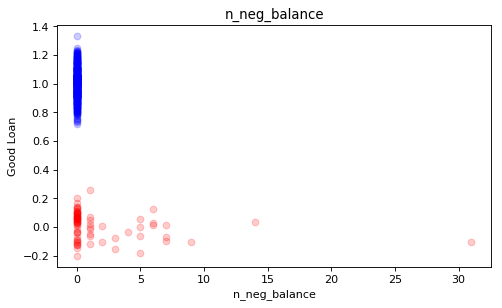

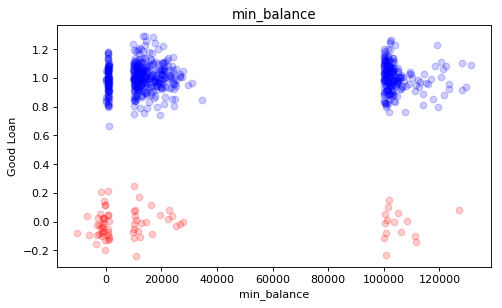

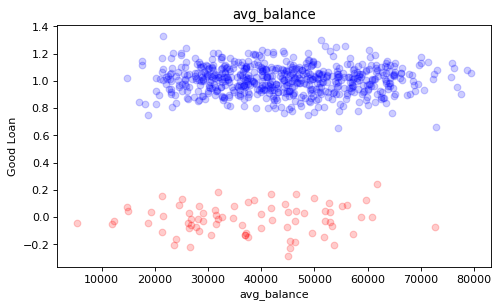

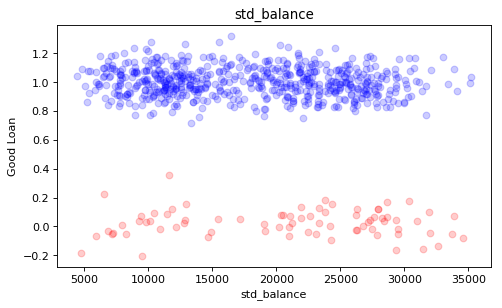

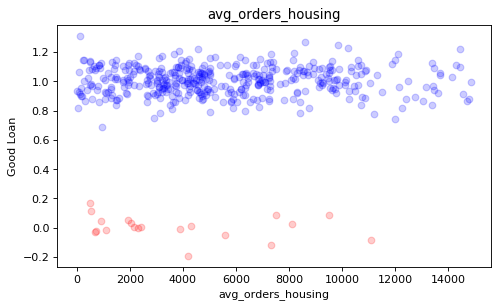

In [9]:
good_loans = loans[loans['good_status_loan']==1]
bad_loans = loans[loans['good_status_loan']==0]
                  
plot_features = ['n_neg_balance','min_balance','avg_balance','std_balance','avg_orders_housing']
for column in plot_features:
        #X_range = np.arange(min(X_train[column]),max(X_train[column]))
        #X_range = np.reshape(a=X_range, newshape=(len(X_range),1))
        plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(good_loans[column],np.random.normal(loc=1, scale=.1, size=len(good_loans)),'bo', alpha = .2)
        plt.plot(bad_loans[column],np.random.normal(loc=0, scale=.1, size=len(bad_loans)),'ro', alpha = .2)
        #plt.plot(X_range,np.ones(len(X_range))*.975, 'g', alpha = 1, lw=5)
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('Good Loan')
        plt.show()

In [10]:
from imblearn.pipeline import make_pipeline

In [13]:
ros = RandomOverSampler()
clf = LogisticRegression()
lr_os = make_pipeline(ros, clf)


In [15]:
nreps = 10
alls=[]
tests=[]
pools=[]

param_grid = {'logisticregression__C':[1e-3,3e-3,.01,.03,.1,.3,1,3,10]}
for rep in range(nreps):
    grid_lr_os = GridSearchCV(lr_os, 
                              param_grid=param_grid, 
                              scoring = 'recall')
    
    grid_lr_os.fit(X_train, y_train)
    
    all_predict = grid_lr_os.predict_proba(X)[:,1]
    test_predict = grid_lr_os.predict_proba(X_test)[:,1]
    pool_predict = grid_lr_os.predict_proba(pool)[:,1]
    
    alls.append(all_predict)
    tests.append(test_predict)
    pools.append(pool_predict)
    

In [17]:
loan_scores = pd.DataFrame(alls).T.set_index(y.index)
loan_scores.columns = ['score_'+str(i) for i in loan_scores.columns]
loan_scores['avg_score'] = loan_scores.mean(axis=1)

loan_scores = loan_scores.merge(pd.DataFrame(y),
                                left_index=True, 
                                right_index=True)

loan_scores.head()

,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,avg_score,good_status_loan
account_id,,,,,,,,,,,,
2,0.924198,0.951000,0.964244,0.943176,0.923789,0.972182,0.953451,0.905972,0.961951,0.937541,0.943750,1
19,0.152093,0.132592,0.193992,0.166627,0.173121,0.160767,0.152861,0.226147,0.286529,0.188680,0.183341,0
25,0.995144,0.996443,0.990290,0.995406,0.992110,0.998353,0.997443,0.989625,0.994777,0.994922,0.994451,1
37,0.231625,0.187206,0.246584,0.233379,0.187220,0.235500,0.164966,0.217291,0.311137,0.279673,0.229458,0
38,0.935070,0.954746,0.968097,0.949424,0.933854,0.973009,0.957558,0.908940,0.963584,0.943023,0.948731,1


In [18]:
test_scores = pd.DataFrame(tests).T.set_index(y_test.index)
test_scores.columns = ['score_'+str(i) for i in test_scores.columns]
test_scores['avg_score'] = test_scores.mean(axis=1)

test_scores = test_scores.merge(pd.DataFrame(y),
                                left_index=True, 
                                right_index=True,
                               how='left')
print('shape of test_scores', test_scores.shape)

test_scores.head()

shape of test_scores (171, 12)


,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,avg_score,good_status_loan
account_id,,,,,,,,,,,,
7542,0.711706,0.726571,0.583837,0.708475,0.705496,0.691528,0.709861,0.625804,0.575727,0.634536,0.667354,1
347,0.116979,0.087975,0.124911,0.110114,0.108402,0.060956,0.100949,0.161462,0.116037,0.122700,0.111049,0
3230,0.469800,0.533801,0.538640,0.509732,0.444724,0.538998,0.674633,0.472029,0.551701,0.495769,0.522983,1
915,0.996453,0.998622,0.996342,0.997688,0.995366,0.999293,0.998968,0.992490,0.996933,0.996751,0.996891,1
6138,0.921789,0.954766,0.943379,0.941757,0.921368,0.968123,0.954233,0.871392,0.943862,0.914720,0.933539,1


In [19]:
pool_scores = pd.DataFrame(pools).T.set_index(pool.index)
pool_scores.columns = ['score_'+str(i) for i in pool_scores.columns]
pool_scores['avg_score'] =pool_scores.mean(axis=1)


print('shape of pool_scores', pool_scores.shape)

pool_scores.head()

shape of pool_scores (3818, 11)


,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,avg_score
account_id,,,,,,,,,,,
1,0.706155,0.392428,0.146737,0.601494,0.636244,0.756589,0.465582,0.740046,0.613902,0.739709,0.579889
3,0.793709,0.462403,0.110155,0.698443,0.612635,0.432244,0.568074,0.649902,0.157313,0.748703,0.523358
4,0.826896,0.885746,0.861025,0.759688,0.874761,0.985716,0.799389,0.752966,0.978833,0.759449,0.848447
5,0.874197,0.908663,0.854961,0.865528,0.899746,0.965895,0.906845,0.842498,0.936941,0.860782,0.891606
6,0.934357,0.944903,0.905101,0.901954,0.951875,0.995572,0.921268,0.909121,0.992004,0.914121,0.937028


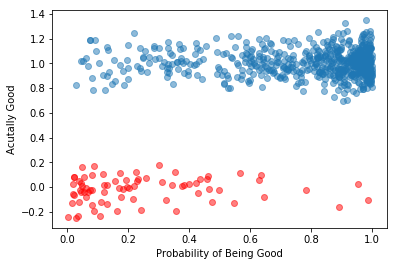

In [22]:
# Examine Predictions for test set
good_loans = loan_scores[loan_scores.good_status_loan == 1]['avg_score']
bad_loans = loan_scores[loan_scores.good_status_loan == 0]['avg_score']


plt.plot(good_loans, np.random.normal(1,.1, len(good_loans)), 'o', alpha=.5)
plt.plot(bad_loans, np.random.normal(0,.1, len(bad_loans)), 'ro', alpha = .5)
plt.xlabel('Probability of Being Good')
plt.ylabel('Acutally Good')
plt.show()

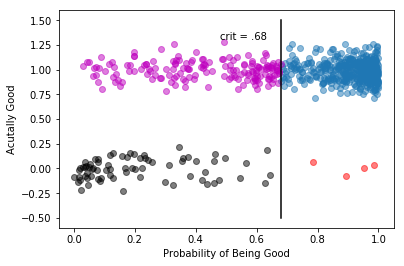

In [23]:
crit = 0.68
true_good = good_loans[good_loans>=crit]
false_good = bad_loans[bad_loans>=crit]
true_bad = bad_loans[bad_loans<crit]
false_bad = good_loans[good_loans<crit]

plt.plot(true_good, np.random.normal(1,.1, len(true_good)), 'o', alpha=.5)
plt.plot(false_bad, np.random.normal(1,.1, len(false_bad)), 'mo', alpha=.5)
plt.plot(true_bad, np.random.normal(0,.1, len(true_bad)), 'ko', alpha = .5)
plt.plot(false_good, np.random.normal(0,.1, len(false_good)), 'ro', alpha = .5)
plt.plot([crit,crit],[1.5, -.5], 'k')
plt.text(crit-.2,1.3,'crit = .68')
plt.xlabel('Probability of Being Good')
plt.ylabel('Acutally Good')
plt.show()

In [24]:
crit_list=[]
fb_list=[]
tb_list=[]

for crit in np.arange(0,1.01,.01):
    FalsePositives = len(bad_loans[bad_loans>crit])
    TruePositives = len(good_loans[good_loans>crit])
    FalsePositives,TruePositives
    
    crit_list.append(crit)
    fb_list.append(FalsePositives/len(bad_loans))
    tb_list.append(TruePositives/len(good_loans))

roc_table = pd.DataFrame({'crit': crit_list, 
                          'FalsePositive': fb_list, 
                          'TruePositive':tb_list})

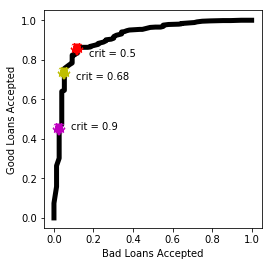

In [25]:
choose_crit = .68
plt.plot(roc_table['FalsePositive'], roc_table['TruePositive'], lw=5, color='k')
plt.xlabel('Bad Loans Accepted')
plt.ylabel('Good Loans Accepted')
plt.plot(roc_table[roc_table.crit==choose_crit]['FalsePositive'], 
         roc_table[roc_table.crit==choose_crit]['TruePositive'], 'y*', markeredgewidth=10)
plt.text(roc_table[roc_table.crit==choose_crit]['FalsePositive']+0.06, 
         roc_table[roc_table.crit==choose_crit]['TruePositive']-.03, 'crit = ' + str(choose_crit))
plt.plot(roc_table[roc_table.crit==.9]['FalsePositive'], 
         roc_table[roc_table.crit==.9]['TruePositive'], 'm*', markeredgewidth=10)
plt.text(roc_table[roc_table.crit==.9]['FalsePositive']+0.06, 
         roc_table[roc_table.crit==.9]['TruePositive'], 'crit = ' + str(0.9))
plt.plot(roc_table[roc_table.crit==.5]['FalsePositive'], 
         roc_table[roc_table.crit==.5]['TruePositive'], 'r*', markeredgewidth=10)
plt.text(roc_table[roc_table.crit==.5]['FalsePositive']+0.06, 
         roc_table[roc_table.crit==.5]['TruePositive']-.04, 'crit = ' + str(0.5))
         
plt.axis('square')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.show()

##### y_pred = y_avg_all > choose_crit
print(metrics.classification_report(y,y_pred))

Accounts found with average of 99% probability of being a good loan: 17


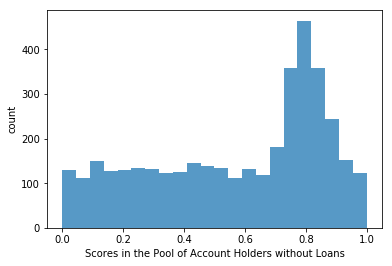

In [30]:
pool_avg_pred = pool_scores.iloc[:,1:].mean(axis=1)
best = pool_avg_pred[pool_avg_pred>=.99]
others =  pool_avg_pred[pool_avg_pred<.99]
print('Accounts found with average of 99% probability of being a good loan:', 
	len(best))

plt.hist(pool_avg_pred, alpha = .75, bins=22)
plt.xlabel('Scores in the Pool of Account Holders without Loans')
plt.ylabel('count')
plt.show()
#plt.savefig('predict_histogram.png', bbox_inches='tight')

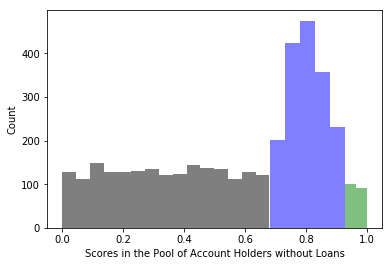

In [29]:
preapprove_c = pool_avg_pred.quantile(q=.95)
approve_c = .68

pool_avg_pred = pool_scores.iloc[:,1:].mean(axis=1)

pre_approve = pool_avg_pred[pool_avg_pred >= preapprove_c]
approve = pool_avg_pred[(pool_avg_pred >= approve_c) &
                       (pool_avg_pred < preapprove_c)]
deny = pool_avg_pred[pool_avg_pred < approve_c]

plt.hist(pre_approve, bins=2, color='g', alpha = 0.5)
plt.hist(approve, bins = 5, color='b', alpha=0.5)
plt.hist(deny, color='k', alpha=.5, bins =15)
plt.xlabel('Scores in the Pool of Account Holders without Loans')
plt.ylabel('Count')
plt.show()